In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
from datetime import datetime, timedelta
from astropy.time import Time
import astropy.units as u
from sunpy.net import Fido, attrs as a
from sunpy.map import Map
from PIL import Image as PILImage, ImageOps
import numpy as np

In [17]:
# Define the paths to the data directory and the output directory.
srs_dir = r"SRS\2014_SRS"
image_dir = r"images"

In [13]:
def parse_srs_file(file_path):
    """
    Parse a Solar Region Summary file and extract sunspot regions information.
    """
    import os  # Importar os aquí para que la función sea autocontenida

    try:
        with open(file_path, "r") as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return []

    regions = []
    region_section = False
    for line in lines:
        line = line.strip()
        if "I.  Regions with Sunspots" in line:
            region_section = True
            continue
        if "IA. H-alpha Plages without Spots" in line:
            region_section = False
            continue
        if region_section and line and not line.startswith("#"):
            parts = line.split()
            if len(parts) >= 8 and parts[0].isdigit():
                try:
                    number = int(parts[0])
                    location = parts[1]
                    longitude = int(parts[2])
                    area = int(parts[3])
                    z = parts[4]
                    l1 = int(parts[5])
                    nn = int(parts[6])
                    mag_type = parts[7]

                    valid_date_str = os.path.basename(file_path).split("SRS")[0]
                    valid_date = datetime.strptime(valid_date_str, "%Y%m%d").strftime(
                        "%Y-%m-%d"
                    )

                    region_data = {
                        "number": number,
                        "location": location,
                        "longitude": longitude,
                        "area": area,
                        "Z": z,
                        "LL": l1,
                        "NN": nn,
                        "mag_type": mag_type,
                        "valid_date": valid_date,
                    }
                    regions.append(region_data)
                except (ValueError, IndexError) as e:
                    print(f"Warning: Skipping malformed line: {line} ({e})")
    return regions

In [ ]:
def download_hmi_image(date_str, out_dir, dt_margin=15):
    """Downloads an HMI continuum image for a given date."""

    valid_date_str = date_str
    t0 = datetime.strptime(valid_date_str, "%Y-%m-%d") - timedelta(days=1)

    print(
        f"[INFO] Fecha ajustada: {t0.isoformat()} (basado en valid_date {valid_date_str})"
    )

    # Ampliar margen de búsqueda (imágenes cada 15 min)
    tstart = t0 - timedelta(minutes=dt_margin)
    tend = t0 + timedelta(minutes=dt_margin)

    print(f"[INFO] Buscando imagen HMI para intervalo: {tstart} → {tend}")

    # Búsqueda optimizada para imágenes HMI
    q = Fido.search(
        a.Time(tstart, tend),
        a.Instrument("HMI"),
        a.Physobs.intensity,
        a.Wavelength(6173 * u.angstrom),
        a.Sample((dt_margin * 60) * u.second),  # or the appropriate unit
    )

    if len(q) == 0 or len(q[0]) == 0:
        print(f"[ERROR] No se encontraron imágenes para {t0.isoformat()}")
        return None

    # Seleccionar la imagen más cercana al tiempo objetivo
    best_index = 0
    smallest_diff = float("inf")
    for i in range(len(q[0])):
        img_time = q[0]["Start Time"][i]
        # time_diff = abs((img_time - t0).total_seconds())
        t0_astropy = Time(t0)
        time_diff = abs((img_time - t0_astropy).sec)
        if time_diff < smallest_diff:
            smallest_diff = time_diff
            best_index = i

    best_img = q[0][best_index]
    found_time = best_img["Start Time"]
    print(
        f"[OK] Imagen encontrada en {found_time} (diferencia: {smallest_diff:.0f} segundos)"
    )

    # Descargar la imagen
    date_folder = os.path.join(out_dir, t0.strftime("%Y-%m-%d"))
    os.makedirs(date_folder, exist_ok=True)

    try:
        files = Fido.fetch(best_img, path=date_folder)
        print(f"[DESCARGADO] Imagen guardada en: {files[0]}")
        return files[0]
    except Exception as e:
        print(f"[ERROR] Descarga fallida: {str(e)}")
        return None

In [15]:
def fits_to_jpeg(fits_path: str, jpeg_path: str, quality: int = 80):
    """Carga FITS con SunPy, normaliza datos a 8-bit y guarda como JPG."""
    try:
        smap = Map(fits_path)
        data = smap.data.astype(float)
        norm = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
        norm = np.nan_to_num(norm)
        img8 = (np.clip(norm, 0, 1) * 255).astype(np.uint8)
        pil = PILImage.fromarray(img8)
        pil = ImageOps.equalize(pil)
        pil.save(jpeg_path, "JPEG", quality=quality)
        print(f"Convertido {fits_path} → {jpeg_path}")
    except Exception as e:
        print(f"Error al convertir {fits_path}: {e}")
        return None
    return jpeg_path

In [18]:
# Select an SRS file to process.
srs_file = os.path.join(
    srs_dir, "20140101SRS.txt"
)  # Replace with your desired SRS file

# Parse the SRS file using the `parse_srs_file` function.
regions = parse_srs_file(srs_file)

# Convert the parsed data to a Pandas DataFrame for easier analysis.
df = pd.DataFrame(regions)
df

,number,location,longitude,area,Z,LL,NN,mag_type,valid_date
0,1934,S16W83,272,80,Eac,11,5,Beta-Gamma-Delta,2014-01-01
1,1936,S16W36,225,280,Eac,14,36,Beta-Gamma-Delta,2014-01-01
2,1937,S12W09,198,10,Bxo,4,3,Beta,2014-01-01
3,1938,S09E09,179,30,Hax,2,3,Alpha,2014-01-01
4,1940,S12W44,233,20,Dro,4,4,Beta,2014-01-01
5,1941,S13W22,211,30,Dro,4,3,Beta,2014-01-01
6,1942,N10E62,127,20,Hrx,1,1,Alpha,2014-01-01
7,1943,S11E67,122,20,Cro,1,1,Beta,2014-01-01


Using date: 2014-01-01 for image download
[INFO] Fecha ajustada: 2013-12-31T00:00:00 (basado en valid_date 2014-01-01)
[INFO] Buscando imagen HMI para intervalo: 2013-12-30 23:45:00 → 2013-12-31 00:15:00
[OK] Imagen encontrada en 2013-12-31 00:00:24.000 (diferencia: 24 segundos)


Files Downloaded: 100%|██████████| 1/1 [00:14<00:00, 14.44s/file]


[DESCARGADO] Imagen guardada en: images\2013-12-31\hmi.ic_45s.2013.12.31_00_01_30_TAI.continuum.fits
Convertido images\2013-12-31\hmi.ic_45s.2013.12.31_00_01_30_TAI.continuum.fits → images\2013-12-31\hmi.ic_45s.2013.12.31_00_01_30_TAI.continuum.jpg


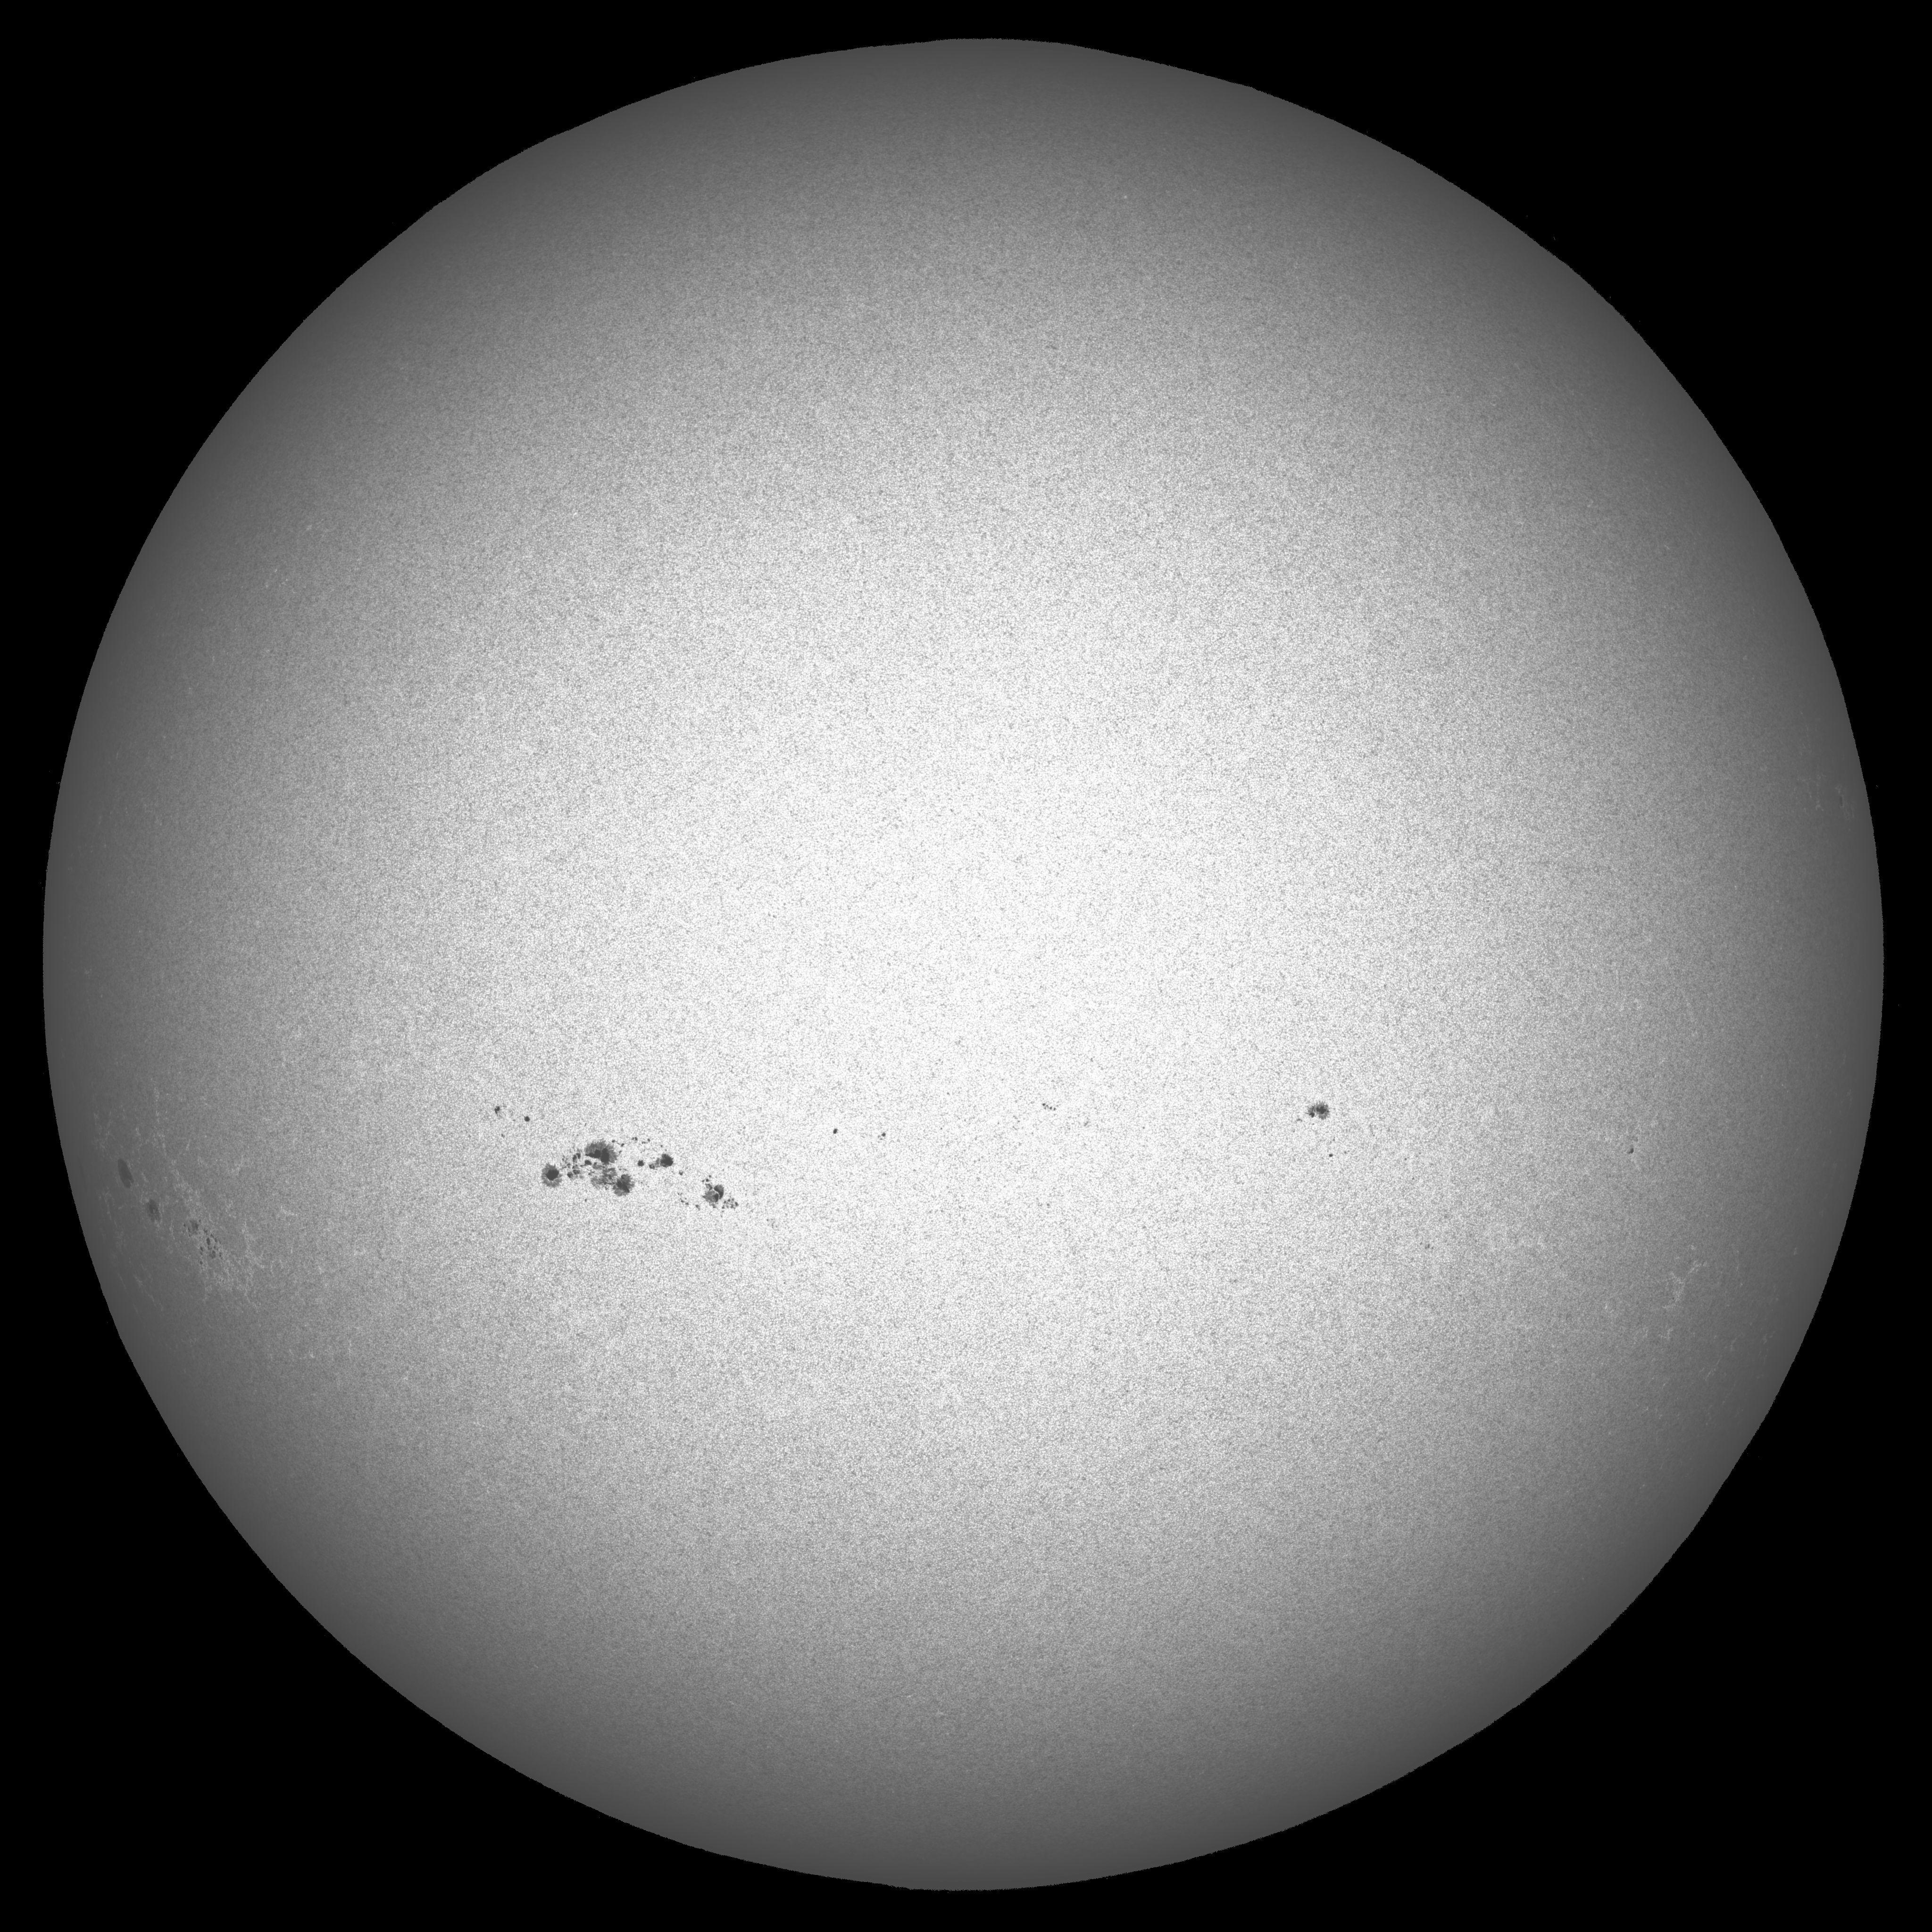

In [ ]:
# Extract the valid date from the SRS data to use for image download.
if regions:
    valid_date_str = regions[0]["valid_date"]
    t0 = pd.to_datetime(valid_date_str)
    date_str = t0.strftime("%Y-%m-%d")
    print(f"Using date: {date_str} for image download")

    # Download the corresponding solar image using the `download_hmi_image` function.
    fits_path = download_hmi_image(date_str, image_dir)

    # Convert the downloaded FITS image to JPG format using the `fits_to_jpeg` function.
    if fits_path:
        jpg_path = fits_path.replace(".fits", ".jpg")
        jpg_path = fits_to_jpeg(fits_path, jpg_path)

        if jpg_path:
            # Display the downloaded JPG image.
            try:
                display(Image(filename=jpg_path))
            except FileNotFoundError:
                print(f"Error: Could not find the image {jpg_path}")
    else:
        print("FITS file not downloaded, cannot convert to JPG.")
else:
    print("No regions found in SRS data. Skipping image download.")

Falta realizar la conversion de las cordenadas y ponerlas en la imagen para luego poder anotarlo en formato para que sea usado por YOLO y así poder crear mi propio dataset ya que además incluye las clasificaciones.